In [50]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
my_font = FontProperties(fname=r"c:\windows\fonts\SimHei.ttf",size=12)

In [2]:
class WindDataSet(Dataset):
    def __init__(self,path,num_steps=50):
        self.data = []
        file = pd.read_csv(path,skiprows=1)
        self.feature = np.array(file[[ "Month", "Day", "Hour", "Minute", "surface air pressure (Pa)", "relative humidity at 2m (%)", "surface precipitation rate (mm/h)", "air temperature at 10m (C)", "wind direction at 10m (deg)","wind speed at 10m (m/s)"]])
        self.target = np.array(file["wind speed at 10m (m/s)"])
        wind_len = len(self.feature)
        for i in range(wind_len-num_steps-1):
            self.data.append((self.feature[i:i+num_steps],self.target[i+num_steps]))
        self.data = self.data[:int(len(self.data)/250)*250]
    def __len__(self):
        return len(self.data)   
    def __getitem__(self,index):
        seq,pre = self.data[index]
        return seq,pre


In [3]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
try_gpu()

device(type='cpu')

In [4]:
INPUT_SIZE=10
HIDDEN_SIZE=50
BATCH_SIZE=250
OUTPUT_SIZE=1
NUM_LAYERS=2

class lstm(nn.Module):
    def __init__(self):
        super(lstm,self).__init__()
        self.rnn = nn.LSTM(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE,num_layers=NUM_LAYERS)
        self.fc = nn.Linear(HIDDEN_SIZE,OUTPUT_SIZE)
    def forward(self,x,state):
        x = torch.transpose(x,dim0=0,dim1=1).reshape((x.shape[1],-1,INPUT_SIZE))
        out,state = self.rnn(x,state)
        out = self.fc(out)
        return out[-1],state
    def begin_state(self,batch_size,device):
        return (torch.zeros((2,batch_size,HIDDEN_SIZE),device=device),torch.zeros((2,batch_size, HIDDEN_SIZE), device=device))

In [5]:
net = lstm()
lr = 0.001
device = try_gpu()
print(device)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
loss = nn.MSELoss()
epochs = 1
num_steps=50

cpu


In [6]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [9]:

def train_epoch(epoch,net,train_loader,device,train_loss):
    net = net.to(device)
    net.train()
    runing_loss=0
    for batch_idx,(X,y) in enumerate(train_loader):
        state=net.begin_state(batch_size=BATCH_SIZE, device=device)
        for s in state:
            s.detach_()
        optimizer.zero_grad()
        X,y = X.to(torch.float32).to(device),y.to(torch.float32).T.to(device)
        #print(X.shape,y.shape)
        y_hat,state = net(X,state)
        y_hat = y_hat.reshape(-1)
        l = loss(y_hat,y).mean()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        runing_loss += l.item()
        if batch_idx%400 == 399:
            print(f'epoch:{epoch+1},batch_idx:{batch_idx+1},running_loss:{runing_loss/400}')
            train_loss.append(l.item())
            runing_loss=0


In [8]:
dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144/1.csv',num_steps)
print(dataset.__len__())

105000


In [62]:
def train(epochs):
    train_loss = []
    for epoch in range(epochs):
        for i in range(120):
            dataset = WindDataSet(f'../data/wind_dataset144-2014/wind_dataset144/{i}.csv',num_steps)
            train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0)
            train_epoch(epoch,net,train_loader,device,train_loss)
        print(f'###epoch:{epoch+1},train_loss:{train_loss[-1]}')

In [63]:
train(epochs)

epoch:1,batch_idx:100,running_loss:11.401689472198486
epoch:1,batch_idx:200,running_loss:5.30028207346797
epoch:1,batch_idx:300,running_loss:10.809724660515785
epoch:1,batch_idx:400,running_loss:6.655998198390007
epoch:1,batch_idx:500,running_loss:7.582310383915901
epoch:1,batch_idx:600,running_loss:6.324095398187637
epoch:1,batch_idx:700,running_loss:5.791375670284033
epoch:1,batch_idx:800,running_loss:5.618050145208835
epoch:1,batch_idx:900,running_loss:4.148141819685698
epoch:1,batch_idx:1000,running_loss:6.006547602713108
epoch:1,batch_idx:1100,running_loss:5.520579954683781
epoch:1,batch_idx:1200,running_loss:4.1434146299958226
epoch:1,batch_idx:1300,running_loss:2.9956965965032576
epoch:1,batch_idx:1400,running_loss:4.940356095135212
epoch:1,batch_idx:1500,running_loss:4.86685988008976
epoch:1,batch_idx:1600,running_loss:4.781635450273752
epoch:1,batch_idx:1700,running_loss:3.433061838299036
epoch:1,batch_idx:1800,running_loss:4.869444937855005
epoch:1,batch_idx:1900,running_loss

KeyboardInterrupt: 

In [ ]:
def save_net(path = 'wind_10input.pt', net=None):
    torch.save(net.state_dict(),path)
save_net(net=net)

In [53]:
def load_net(path='multidata-epoch9.pt',net=None):
    net.load_state_dict(torch.load(path))
load_net(net=net)

In [80]:
def predict(prefix,postfix,num_preds,net,device):
    net.eval()
    state = net.begin_state(batch_size=1,device=device)
    outputs = [prefix[0]]
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape(1,1,INPUT_SIZE)
    for y in prefix[1:]:
        _,state = net(get_input(),state)
        outputs.append(y)
    for i in range(num_preds):
        p = postfix[i]
        y_hat,state = net(get_input(),state)
        p[-1] = y_hat
        outputs.append(p)
    tmp = []
    for t in outputs:
        tmp.append(t[-1])
    outputs =tmp
    return outputs[-num_preds:]#torch.cat(outputs,dim=1)


In [81]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144/142.csv',num_steps=100)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truthes=[],[]
for batch_idx,(X, y) in enumerate(test_loader):
    if batch_idx > 100:
                break
    X = np.array(X.to(torch.float32).reshape(-1,INPUT_SIZE))
    pred = predict(X,X,1,net.to(device),device)
    truth = np.array(y).reshape(-1)[-1]
    preds.append(np.array(pred)[-1])
    truthes.append(truth)
print((preds))
print((truthes))



(tensor([[5.8714]], grad_fn=<SelectBackward0>), (tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  7.6159e-01, -1.0000e+00, -7.6159e-01,  0.0000e+00,
           0.0000e+00,  0.0000e+00, -7.6159e-01,  0.0000e+00,  1.0000e+00,
          -7.6159e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  7.6159e-01,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           1.0000e+00,  1.0000e+00, -0.0000e+00, -0.0000e+00,  7.6159e-01,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00, -7.6159e-01,  0.0000e+00, -0.0000e+00]],

        [[ 1.0000e+00, -6.5630e-09,  1.0000e+00, -1.0000e+00,  1.0000e+00,
          -4.4660e-09, -1.0000e+00,  1.0000e+00, -1.0000e+00,  4.4700e-09,
          -1.0000e+00, -1.0000e+00,  1.0000e+00,

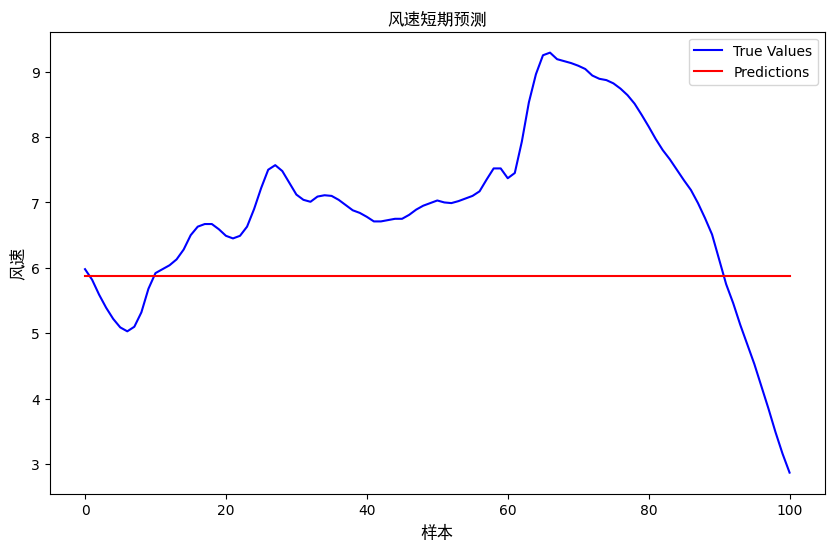

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(truthes, label='True Values', color='blue')
plt.plot(preds, label='Predictions', color='red')
plt.title('风速短期预测',fontproperties=my_font)
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()

In [73]:
y = net(torch.tensor([[[1.0000e+00,  1.0000e+00,  8.0000e+00,  1.5000e+01,  7.9900e+04,
           8.3680e+01,  0.0000e+00, -4.4700e+00,  2.7400e+02,  6.0400e+00]]],dtype=torch.float32),None)
print(y)

(tensor([[1.4684]], grad_fn=<SelectBackward0>), (tensor([[[ 0.0000,  0.0000,  0.0000,  0.7616,  0.0000,  0.0000,  0.7616,
          -0.7616, -0.7616,  0.0000,  0.0000,  0.0000, -0.7616,  0.0000,
           0.7616, -0.7616,  0.0000,  0.0000,  0.0000,  0.7616,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
           0.7616,  0.7616, -0.0000, -0.0000,  0.7616,  0.0000,  0.0000,
           0.0000,  0.0000,  0.7616,  0.0000,  0.0000, -0.7616,  0.0000,
          -0.0000]],

        [[ 0.4000, -0.0070,  0.2817, -0.1985,  0.2602, -0.0129, -0.0446,
           0.0903,  0.0145,  0.0098, -0.0720, -0.1989,  0.2750,  0.0050,
          -0.2898, -0.3063, -0.2468,  0.1519, -0.1387,  0.1553, -0.2555,
          -0.4068,  0.2658, -0.2025,  0.0090,  0.2686, -0.2241,  0.2697,
          -0.3908, -0.3200,  0.1555,  0.3041, -0.2777,  0.3477, -0.1532,
          -0.1780,  0.2577, -0.2372, -0.3429,  0.0017

In [72]:
print(y)

(tensor([[0.2581]], grad_fn=<SelectBackward0>), (tensor([[[ 0.0111, -0.2710,  0.2017,  0.0543, -0.0262, -0.0650,  0.2248,
           0.1905,  0.3326,  0.0404, -0.1365, -0.0293, -0.2881,  0.1022,
           0.2630,  0.4576,  0.0046,  0.4824,  0.0257, -0.3367,  0.3281,
           0.0176,  0.3166, -0.1752,  0.1274, -0.1601,  0.0297,  0.6150,
          -0.2257, -0.2476, -0.0320,  0.0256,  0.0463, -0.1127,  0.5076,
           0.3801,  0.2034, -0.4796, -0.2606,  0.0820,  0.0199, -0.4628,
          -0.0967, -0.6146, -0.0700, -0.0319, -0.0974,  0.0703, -0.0550,
          -0.0280]],

        [[ 0.0946, -0.0429,  0.0927,  0.0132, -0.0024, -0.0161, -0.0225,
           0.0583,  0.0121,  0.0171,  0.0295, -0.0298,  0.0074,  0.0377,
          -0.0544, -0.0491, -0.0045, -0.0046, -0.0032, -0.0784, -0.0594,
          -0.0271, -0.0446,  0.0686,  0.0481,  0.0164, -0.0651,  0.0479,
          -0.0550, -0.0195,  0.1234,  0.0289, -0.0487,  0.0769,  0.0104,
          -0.0074, -0.0354, -0.0762,  0.0059,  0.0428